In [1]:
#Carga de librerias
import glob
import pandas
import networkx
import numpy
import gc
import matplotlib.pyplot as plt
import pyproj
import folium
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral3
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from folium import plugins
import math
#pyproj.pyproj_datadir = "/usr/share/proj/"
#from mpl_toolkits.basemap import Basemap as Basemap
def SufijoColumna(Data,suf):
    i=Data
    final=[]
    for c in i:
        final.append(c+suf)
    return final
pandas.options.display.float_format = '{:.2f}'.format # Configuramos separadores de miles y 2 decimales
#Carga de Datos
a=glob.glob("../../Transito/Mercancias/EstadisticasRNDC_201*")
municipios=pandas.read_excel("../../mpio/Municipios_Dane_Ubicados.xlsx", header=0)
municipios_ori=pandas.read_excel("../../mpio/Municipios_Dane_Ubicados.xlsx", header=0)
NameMunicipios=municipios_ori.columns
municipios_ori.columns =SufijoColumna(NameMunicipios,"_Ori")
municipios_dest=pandas.read_excel("../../mpio/Municipios_Dane_Ubicados.xlsx", header=0)
NameMunicipios=municipios_dest.columns
municipios_dest.columns =SufijoColumna(NameMunicipios,"_Dest")
for b in a:
    A1=pandas.read_excel(b, header=0)
    A1["Tiempo"]=str(A1["MES"])
    try:
        A2=A2.append(A1,ignore_index=True,sort=True)
    except:
        A2=A1
        print("NO")
#Marcar posisiones de todos los municipios con el centroide ya determinado        
pos={}
for er in municipios.Id:
    pos[int(er)]=(municipios.Long2.loc[municipios['Id'] == er].values[0],municipios.lat.loc[municipios['Id'] == er].values[0])
A2.info()
municipios.info()


NO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5482674 entries, 0 to 5482673
Data columns (total 24 columns):
CODMERCANCIA              object
CODMUNICIPIODESTINO       int64
CODMUNICIPIOORIGEN        int64
CODOPERACIONTRANSPORTE    object
CODTIPOCONTENEDOR         object
COD_CONFIG_VEHICULO       object
CONFIG_VEHICULO           object
DEPARTAMENTODESTINO       object
DEPARTAMENTOORIGEN        object
GALONES                   int64
KILOGRAMOS                int64
KILOMETROS                int64
MERCANCIA                 object
MES                       int64
MUNICIPIODESTINO          object
MUNICIPIOORIGEN           object
NATURALEZACARGA           object
OPERACIONTRANSPORTE       object
TIPOCONTENEDOR            object
Tiempo                    object
VALORESPAGADOS            int64
VIAJESLIQUIDOS            int64
VIAJESTOTALES             int64
VIAJESVALORCERO           int64
dtypes: int64(10), object(14)
memory usage: 1003.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeInde

Pruebas previas para determinar aspectos basicos de la base de datos:

In [2]:
#Pruebas de la base de datos
print(" La cantidad de registros es:", A2["CODMERCANCIA"].count())

 La cantidad de registros es: 5482674


In [3]:
municipios_dest.columns

Index(['AREA_Dest', 'PERIMETER_Dest', 'WCOLGEN02__Dest', 'WCOLGEN021_Dest',
       'DPTO_Dest', 'NOMBRE_DPT_Dest', 'MPIO_Dest', 'label_Dest',
       'NOMBRE_CAB_Dest', 'CLASEMUN_Dest', 'Id_Dest', 'ZONA_Dest',
       'OF_REG_Dest', 'REG_ZONAS_Dest', 'HECTARES_Dest', 'lat_Dest',
       'Long2_Dest'],
      dtype='object')

In [4]:
#Datos Faltantes
A2.isnull().any().any()

True

In [5]:
 #Agrupando columnas por tipo de datos
tipos = A2.columns.to_series().groupby(A2.dtypes).groups

# Armando lista de columnas categóricas
ctext = tipos[numpy.dtype('object')]
len(ctext)  # cantidad de columnas con datos categóricos. 



14

In [6]:
# Armando lista de columnas numéricas
columnas = A2.columns  # lista de todas las columnas
cnum = list(set(columnas) - set(ctext))
len(cnum)

10

Aqui se realizan Cambios de formato de Celdas y de informacion para analisis. 

In [7]:
#Cambios en la base de datos
def CodigoDane(Completo):# Se gereran Codigo dane con un formato estanddar Ademas de ver codigos truncados o con pocos digitos.
    Completo=str(Completo)
    Tam=len(Completo)
    if Tam<6:
        Cortado=99999
    else:
        Cortado=int(Completo[:Tam-3])       
    return Cortado
def BuscadorMiel(Texto):#Funcios Buscar textos que contengan miel natural.
    try:
        Temp=str(Texto).lower().count("miel natural")
    except:
        return 3
    return Temp
def BuscadorAbeja(Texto):
    try:
        Temp=str(Texto).lower().count("abeja")
    except:
        return 3
    return Temp
def BuscadorApicultura(Texto):
    try:
        Temp=str(Texto).lower().count("polen")
    except:
        return 3
    return Temp
def TemporizadorAge(Texto):
    Salida=str(Texto)[:4]
    return Salida
def TemporizadorMes(Texto):
    Salida=str(Texto)[4:]
    return Salida
def ConvInteger(temp):
    try:
        final=int(temp)
    except:
        final=0
    return final
def ConvLog(temp):
    try:
        final=math.log10(temp)
    except:
        final=9999999
    return final
def frange(start, stop=None, step=None):
    if stop == None:
        stop = start + 0.0
        start = 0.0
    if step == None:
        step = 1.0
    while True:
        if step > 0 and start >= stop:
            break
        elif step < 0 and start <= stop:
            break
        yield ("%g" % start) # return float number
        start = start + step

A2["CODMUNICIPIOORIGEN2"]=A2["CODMUNICIPIOORIGEN"].apply(CodigoDane)
A2["CODMUNICIPIODESTINO2" ]=A2["CODMUNICIPIODESTINO" ].apply(CodigoDane)
A3=pandas.merge(A2, municipios_ori, left_on='CODMUNICIPIOORIGEN2', right_on='Id_Ori',how="left")
A4=pandas.merge(A3, municipios_dest, left_on='CODMUNICIPIODESTINO2', right_on='Id_Dest',how="left")
A4["Miel"]=A4["MERCANCIA"].apply(BuscadorMiel)
A4["Recorrido"]=A4["NOMBRE_DPT_Ori"]+"/"+A4["label_Ori"]+"_"+A4["NOMBRE_DPT_Dest"]+"/"+A4["label_Dest"]
A4["PesoTotalizado"]=A4['KILOGRAMOS']+A4['GALONES']*3.78541*1.46
A4["PesoTotalizadolog"]=A4["PesoTotalizado"].apply(ConvLog)
A4["Age"]=A4["MES"].apply(TemporizadorAge)
A4["MesF"]=A4["MES"].apply(TemporizadorMes)
A4["Id_Ori2"]=A4["Id_Ori"].apply(ConvInteger)
A4["Id_Dest2"]=A4["Id_Dest"].apply(ConvInteger)
A4["DateComplete"]=A4["Age"]+"/"+A4["MesF"] +"/"+"01"
A4['DateComplete'] = pandas.to_datetime(A4['DateComplete'], format='%Y/%m/%d')

Desde Aca se empiezan a generar salidas de infroamcion del analisis

In [8]:
# Calculando el porcentaje de donantes sobre toda la base de datos
Porcentaje_ViajesMiel = (A4[A4.Miel 
                             == 1]['CODMERCANCIA'].count() * 1.0
       / A4['CODMERCANCIA'].count()) * 100.0
print("El procentaje de Viajes con miel de la base de datos es {0:.2f}%"
      .format(Porcentaje_ViajesMiel))


El procentaje de Viajes con miel de la base de datos es 0.03%


In [9]:
#Este paso es opcional cuando esto ea muy pesado
#Eliminar informacion que hace el proceso pesado
#A1=0
#A3=0
#del A1
#del A3
#A4.info()
#gc.collect()

In [10]:
#Determinacion de Cuales viajes dicen explicitamente que involucran miel
Miel = A4['Miel'] == 1
A5=A4[Miel]
table = pandas.pivot_table(A5, values=["PesoTotalizado",'VIAJESLIQUIDOS', 'VIAJESTOTALES'], index=['DateComplete','NOMBRE_DPT_Ori', 'label_Ori'],aggfunc=numpy.sum)
print("Reporte minimo en logaritmo", min(A5['PesoTotalizadolog']))
print("Reporte Maximo en logaritmo", max(A5['PesoTotalizadolog']))

Reporte minimo en logaritmo 2.4712917110589387
Reporte Maximo en logaritmo 6.549248556854056


In [11]:
# Analizando el importe de donanciones
# Creando un segmentos de importes
pandas.cut(A5['PesoTotalizado'],15)
#Caracteristicas de Columnas Numericas
for c in cnum: 
    print(c,numpy.min(A5[c].to_list()),numpy.max(A5[c].to_list()),numpy.mean(A5[c].to_list()))

# Completando valores faltantas datos categóricos
for c in ctext:
    print(c,set(A5[c].to_list()))

CODMUNICIPIOORIGEN 5001000 81736000 60035803.478527606
CODMUNICIPIODESTINO 5001000 99001000 35847571.850920245
KILOGRAMOS 0 3542000 75860.94049079754
GALONES 0 34610 52.874233128834355
VIAJESLIQUIDOS 0 1 0.004294478527607362
KILOMETROS 0 18504 241.57791411042945
VALORESPAGADOS 0 54810000 3958407.2067484665
VIAJESVALORCERO 0 19 0.15950920245398773
MES 201501 201906 201719.21104294478
VIAJESTOTALES 1 104 2.371165644171779
CODMERCANCIA {'000409'}
CODOPERACIONTRANSPORTE {'Y', 'V', 'G'}
CODTIPOCONTENEDOR {'.', 'C'}
COD_CONFIG_VEHICULO {'3S3', '4', '2S2', '3', '3S2', '2S3', '2'}
CONFIG_VEHICULO {'Camión Rígido de 3 ejes ', 'Tractocamión de 2 ejes Semiremolque de 2 Ejes', 'Tractocamión de 3 ejes Semiremolque de 2 Ejes', 'Camión Rígido de 4 ejes ', 'Tractocamión de 2 ejes Semiremolque de 3 Ejes', 'Tractocamión de 3 ejes Semiremolque de 3 Ejes', 'Camión Rígido de 2 ejes '}
DEPARTAMENTODESTINO {nan, 'CESAR', 'CHOCO', 'BOGOTA D. C.', 'RISARALDA', 'CAUCA', 'CAQUETA', 'CUNDINAMARCA', 'TOLIMA', 'MAG

In [12]:
#Estadistica Basica de la base de datos
print("Cantidad de documentos de RNDC. Registro Nacional Despachos de Carga por Carretera relacionados con miel ", len(A5)," de un total de ", len(A4))
print( "Las variables son:")
A5.info()
print("Meses de envios ",A5["DateComplete"].unique())
print("Codigos de mercancia ",A5["CODMERCANCIA"].unique())
print("Mercancia ",A5["MERCANCIA"].unique())
print("Codigo Operacion de transporte ",A5["CODOPERACIONTRANSPORTE"].unique())
print("Operacion de trasporte ",A5["OPERACIONTRANSPORTE"].unique())
print("Codigo Tipo de Contenedor ",A5["CODTIPOCONTENEDOR"].unique())
print("Tipo de contenedor ",A5["TIPOCONTENEDOR"].unique())
print("Codigo configuracion de Vehiculo ",A5["COD_CONFIG_VEHICULO"].unique())
print("Configuracion tipo de Vehiculo ",A5["CONFIG_VEHICULO"].unique())

Cantidad de documentos de RNDC. Registro Nacional Despachos de Carga por Carretera relacionados con miel  1630  de un total de  5483860
Las variables son:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1630 entries, 947 to 5481252
Data columns (total 69 columns):
CODMERCANCIA              1630 non-null object
CODMUNICIPIODESTINO       1630 non-null int64
CODMUNICIPIOORIGEN        1630 non-null int64
CODOPERACIONTRANSPORTE    1630 non-null object
CODTIPOCONTENEDOR         1630 non-null object
COD_CONFIG_VEHICULO       1630 non-null object
CONFIG_VEHICULO           1630 non-null object
DEPARTAMENTODESTINO       231 non-null object
DEPARTAMENTOORIGEN        231 non-null object
GALONES                   1630 non-null int64
KILOGRAMOS                1630 non-null int64
KILOMETROS                1630 non-null int64
MERCANCIA                 1630 non-null object
MES                       1630 non-null int64
MUNICIPIODESTINO          1630 non-null object
MUNICIPIOORIGEN           1630 non-n

In [13]:
#Bases de datos con informacion
Final=pandas.pivot_table(A5, values=["PesoTotalizado",'VIAJESLIQUIDOS', 'VIAJESTOTALES'], index=['DateComplete','NOMBRE_DPT_Ori', 'label_Ori'],aggfunc=numpy.sum)
Final2=pandas.pivot_table(A5, values=["PesoTotalizado",'VIAJESLIQUIDOS', 'VIAJESTOTALES'], index=['DateComplete','NOMBRE_DPT_Dest', 'label_Dest'],aggfunc=numpy.sum)
Final3=pandas.pivot_table(A5, values=["PesoTotalizado",'VIAJESLIQUIDOS', 'VIAJESTOTALES'], index=['DateComplete',"Recorrido","CODMUNICIPIOORIGEN2","CODMUNICIPIODESTINO2","lat_Dest","Long2_Dest","lat_Ori","Long2_Ori"],aggfunc=numpy.sum)
OrigenPeso=pandas.pivot_table(A5, values=["PesoTotalizado"],index=["Id_Ori2"],aggfunc=numpy.sum)
DestinoPeso=pandas.pivot_table(A5, values=["PesoTotalizado"],index=["Id_Dest2"],aggfunc=numpy.sum)
Final4=pandas.pivot_table(A5, values=["PesoTotalizado", 'VIAJESTOTALES'], index=["CODMUNICIPIOORIGEN2","CODMUNICIPIODESTINO2",'MES'],aggfunc=numpy.sum)
Final5=pandas.pivot_table(A5, values=["PesoTotalizado", 'VIAJESTOTALES'], index=["CODMUNICIPIOORIGEN2","CODMUNICIPIODESTINO2"],aggfunc=numpy.sum)
Datosmensuales=pandas.pivot_table(A5, values=["PesoTotalizado"], index=['DateComplete'],aggfunc=numpy.sum)
DatosVehiculos=pandas.pivot_table(A5, values=["PesoTotalizado"], index=['CONFIG_VEHICULO'],aggfunc=numpy.sum)
TransporteMun=pandas.pivot_table(A5, values=["PesoTotalizado"], index=["MUNICIPIOORIGEN","MUNICIPIODESTINO"],aggfunc=numpy.sum)
OrigenMunicipios=pandas.pivot_table(A5, values=["PesoTotalizado"], index=["MUNICIPIOORIGEN"],aggfunc=numpy.sum)
DestinoMunicipios=pandas.pivot_table(A5, values=["PesoTotalizado"], index=["MUNICIPIODESTINO"],aggfunc=numpy.sum)

#print(Datosmensuales)
#print(DatosVehiculos)



In [14]:
#Ranquiin de los diez mayores en varios aspectos
SalidaDestinos=DestinoMunicipios.sort_values(by='PesoTotalizado', ascending=False).iloc[0:10]
SalidaOrigen=OrigenMunicipios.sort_values(by='PesoTotalizado', ascending=False).iloc[0:10]
SalidaMunin=TransporteMun.sort_values(by='PesoTotalizado', ascending=False).iloc[0:10]
print("Los 10 destinos más grandes del transporte de Miel")
print(SalidaDestinos.to_html())
print("Los 10 lugrares de origen más grandes del transporte de Miel")
print(SalidaOrigen.to_html())
print("Las 10 rutas  más grandes del transporte de Miel")
print(SalidaMunin.to_html())

Los 10 destinos más grandes del transporte de Miel
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>PesoTotalizado</th>
    </tr>
    <tr>
      <th>MUNICIPIODESTINO</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BUENAVENTURA VALLE DEL CAUCA</th>
      <td>20930840.00</td>
    </tr>
    <tr>
      <th>PALMIRA VALLE DEL CAUCA</th>
      <td>15415210.00</td>
    </tr>
    <tr>
      <th>MEDELLIN ANTIOQUIA</th>
      <td>15140766.67</td>
    </tr>
    <tr>
      <th>GUADALAJARA DE BUGA VALLE DEL CAUCA</th>
      <td>12513540.00</td>
    </tr>
    <tr>
      <th>ITAGUI ANTIOQUIA</th>
      <td>9430300.00</td>
    </tr>
    <tr>
      <th>TULUA VALLE DEL CAUCA</th>
      <td>6221000.00</td>
    </tr>
    <tr>
      <th>MOSQUERA CUNDINAMARCA</th>
      <td>6066552.00</td>
    </tr>
    <tr>
      <th>CARTAGO VALLE DEL CAUCA</th>
      <td>4635400.00</td>
    </tr>
    <tr>
      <th>PUERTO BERRIO ANTIOQUIA</t

In [24]:
#Distribucion de envios por Mes
SerieTemporal=dict()
for i in range(2015,2020):
    for ii in range(12):
        temp=(A5["Age"]==str(i)) & (A5["MesF"]=='{:02.0f}'.format(ii+1))
        temp2=A5[temp]
        temp3=temp2["PesoTotalizado"].values
        SerieTemporal['{:02.0f}'.format(ii+1)+"-"+str(i)]=robjects.IntVector(temp3)     
SerieTemporal
Data=SerieTemporal
names=Data.keys()
a=[]
for A in names:
    a.append(Data[A])

file='./Salidas/BoxplotContratosRUT.png'
erd=dict()
grdevices = importr('grDevices')
graphics = importr('graphics')
r_base = importr('base')
stats = importr('stats')   
for i in names:
    erd[str(i)]=robjects.FloatVector(Data[i])
pr= robjects.StrVector(names)
final=list()
for i in erd.keys():
    final.append("erd['"+i+"']")
final=",".join(final)
pvar=robjects.StrVector(final)
grdevices.png(file, width = 1000, height = 500)
print("""graphics.boxplot(%s,names=pr, col = "lightblue", main = "Guias de moviliacion por mes", xlab = "Meses con Guias de movilizacion", log="y")
grdevices.dev_off()
"""%(final))

graphics.boxplot(erd['01-2015'],erd['02-2015'],erd['03-2015'],erd['04-2015'],erd['05-2015'],erd['06-2015'],erd['07-2015'],erd['08-2015'],erd['09-2015'],erd['10-2015'],erd['11-2015'],erd['12-2015'],erd['01-2016'],erd['02-2016'],erd['03-2016'],erd['04-2016'],erd['05-2016'],erd['06-2016'],erd['07-2016'],erd['08-2016'],erd['09-2016'],erd['10-2016'],erd['11-2016'],erd['12-2016'],erd['01-2017'],erd['02-2017'],erd['03-2017'],erd['04-2017'],erd['05-2017'],erd['06-2017'],erd['07-2017'],erd['08-2017'],erd['09-2017'],erd['10-2017'],erd['11-2017'],erd['12-2017'],erd['01-2018'],erd['02-2018'],erd['03-2018'],erd['04-2018'],erd['05-2018'],erd['06-2018'],erd['07-2018'],erd['08-2018'],erd['09-2018'],erd['10-2018'],erd['11-2018'],erd['12-2018'],erd['01-2019'],erd['02-2019'],erd['03-2019'],erd['04-2019'],erd['05-2019'],erd['06-2019'],erd['07-2019'],erd['08-2019'],erd['09-2019'],erd['10-2019'],erd['11-2019'],erd['12-2019'],names=pr, col = "lightblue", main = "Guias de moviliacion por mes", xlab = "Meses c

In [25]:
#Anexar Salida anterior
graphics.boxplot(erd['01-2015'],erd['02-2015'],erd['03-2015'],erd['04-2015'],erd['05-2015'],erd['06-2015'],erd['07-2015'],erd['08-2015'],erd['09-2015'],erd['10-2015'],erd['11-2015'],erd['12-2015'],erd['01-2016'],erd['02-2016'],erd['03-2016'],erd['04-2016'],erd['05-2016'],erd['06-2016'],erd['07-2016'],erd['08-2016'],erd['09-2016'],erd['10-2016'],erd['11-2016'],erd['12-2016'],erd['01-2017'],erd['02-2017'],erd['03-2017'],erd['04-2017'],erd['05-2017'],erd['06-2017'],erd['07-2017'],erd['08-2017'],erd['09-2017'],erd['10-2017'],erd['11-2017'],erd['12-2017'],erd['01-2018'],erd['02-2018'],erd['03-2018'],erd['04-2018'],erd['05-2018'],erd['06-2018'],erd['07-2018'],erd['08-2018'],erd['09-2018'],erd['10-2018'],erd['11-2018'],erd['12-2018'],erd['01-2019'],erd['02-2019'],erd['03-2019'],erd['04-2019'],erd['05-2019'],erd['06-2019'],erd['07-2019'],erd['08-2019'],erd['09-2019'],erd['10-2019'],erd['11-2019'],erd['12-2019'],names=pr, col = "lightblue", main = "Guias de moviliacion por mes", xlab = "Meses con Guias de movilizacion", log="y")
grdevices.dev_off()


2


In [26]:
#Serie de tiempo Mensual
output_file('./Salidas/timeseries_plot_fourmonth.html')
df = A5
#grouped = df.groupby('MSNDATE')['TOTAL_TONS', 'TONS_IC', 'TONS_FRAG'].sum()
grouped = df.groupby(pandas.Grouper(key='DateComplete', freq='2M'))['PesoTotalizado'].sum()
grouped = grouped/1000
print(grouped)
source = ColumnDataSource(grouped.to_frame())
p = figure(x_axis_type='datetime')
p.line(x='DateComplete', y='PesoTotalizado', line_width=2, source=source, legend='Total de Miel')
p.yaxis.axis_label = 'Toneladas de Miel'
show(p)

DateComplete
2015-01-31   4504.78
2015-03-31   5604.44
2015-05-31   1538.80
2015-07-31   8884.75
2015-09-30   7414.17
2015-11-30   2824.57
2016-01-31   2342.87
2016-03-31   1770.00
2016-05-31   5509.59
2016-07-31   3016.72
2016-09-30   1985.40
2016-11-30   4395.58
2017-01-31   5316.44
2017-03-31   4197.98
2017-05-31   4010.97
2017-07-31   3875.18
2017-09-30   6090.70
2017-11-30   5025.45
2018-01-31   3583.57
2018-03-31   4639.56
2018-05-31   3941.74
2018-07-31   5416.40
2018-09-30   5845.35
2018-11-30   4653.10
2019-01-31   3866.42
2019-03-31   7261.95
2019-05-31   4500.68
2019-07-31   2112.50
Freq: 2M, Name: PesoTotalizado, dtype: float64


In [27]:
#Serie de tiempo anual
output_file('./Salidas/timeseries_plot_Age.html')
df = A5
#grouped = df.groupby('MSNDATE')['TOTAL_TONS', 'TONS_IC', 'TONS_FRAG'].sum()
grouped = df.groupby(pandas.Grouper(key='DateComplete', freq='A'))['PesoTotalizado'].sum()
grouped = grouped/1000
print(grouped)
source = ColumnDataSource(grouped.to_frame())
p = figure(x_axis_type='datetime')
p.line(x='DateComplete', y='PesoTotalizado', line_width=2, source=source, legend='Total de Miel')
p.yaxis.axis_label = 'Toneladas de Miel'
show(p)

DateComplete
2015-12-31   31682.71
2016-12-31   21792.86
2017-12-31   26649.73
2018-12-31   27926.23
2019-12-31   16078.13
Freq: A-DEC, Name: PesoTotalizado, dtype: float64


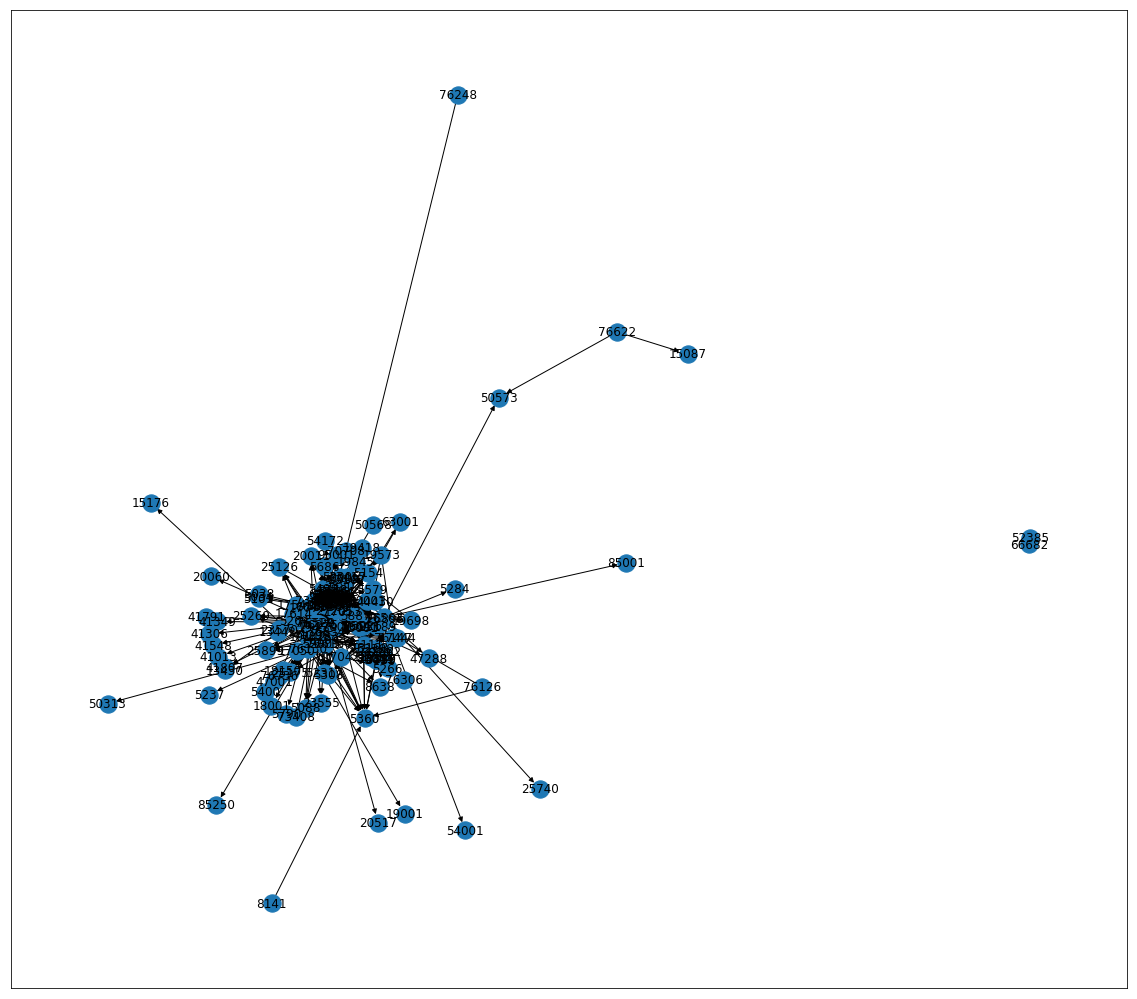

In [28]:
#Grafo
graph = networkx.from_pandas_edgelist(A5,source = 'Id_Ori2', target = 'Id_Dest2', edge_attr = 'PesoTotalizado',create_using = networkx.DiGraph())
plt.figure(figsize = (20,18))
poskamada = networkx.kamada_kawai_layout(graph,weight="PesoTotalizado", scale=5.0)
networkx.draw_networkx(graph, pos=poskamada )

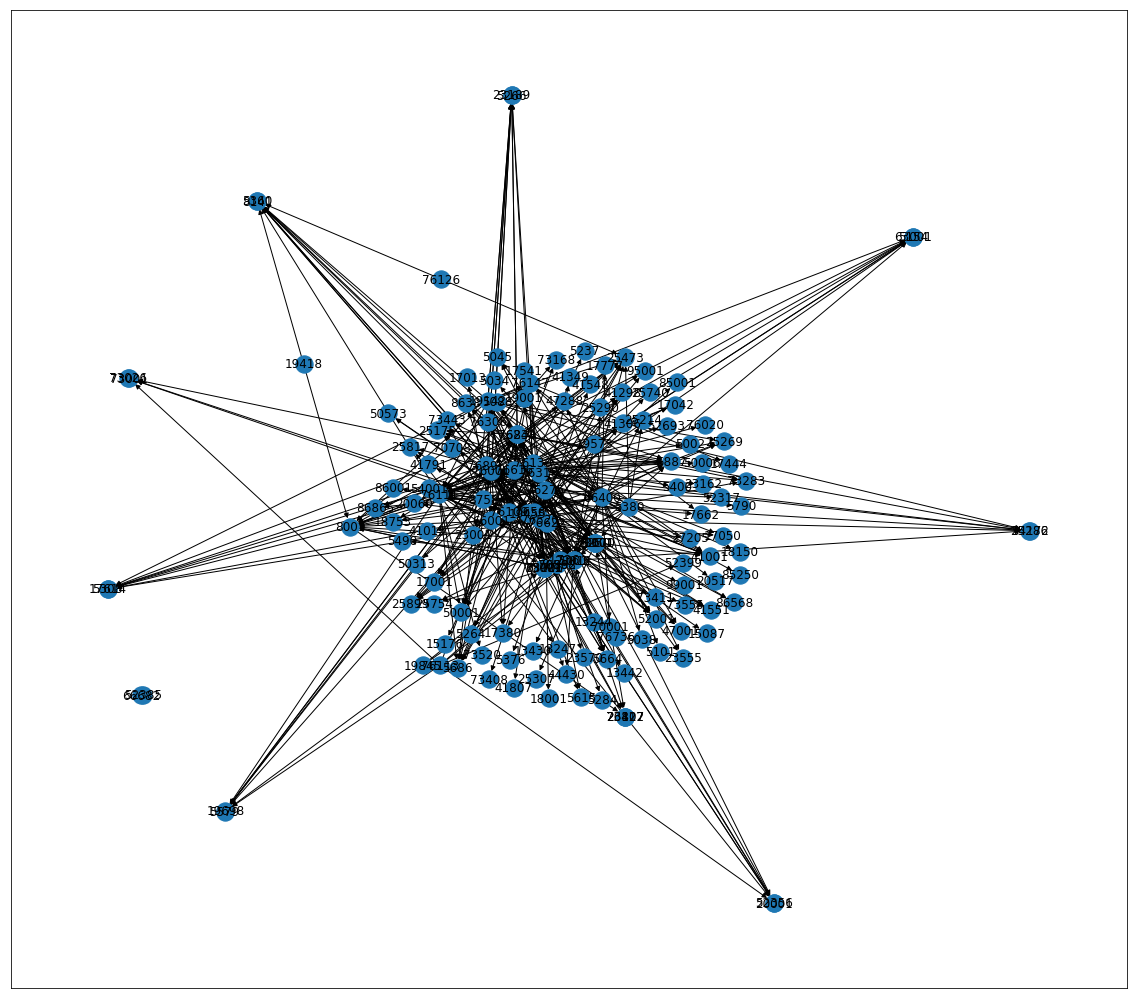

In [29]:
graph = networkx.from_pandas_edgelist(A5,source = 'Id_Ori2', target = 'Id_Dest2', edge_attr = 'PesoTotalizado',create_using = networkx.DiGraph())
plt.figure(figsize = (20,18)) 
posspring=networkx.spring_layout(graph,iterations=5000, threshold=0.000000001,weight="PesoTotalizado", scale=5.0)
networkx.draw_networkx(graph, pos=posspring )

In [34]:
#Grafo kamada
xmin=9999
ymin=9999
xmax=-9999
ymax=-9999
xcue=0
ycue=0
xsum=0
ysum=0
pos5=poskamada
for u in pos5.keys():
    if pos5[u][0]<xmin:
        xmin=pos5[u][0]
    if pos5[u][1]<ymin:
        ymin=pos5[u][1]
    if pos5[u][0]>xmax:
        xmax=pos5[u][0]
    if pos5[u][1]>ymax:
        ymax=pos5[u][1]
    xcue=xcue+1.0
    ycue=ycue+1.0
    xsum=pos5[u][0]+xsum
    ysum=pos5[u][1]+ysum
xpro=xsum/xcue
ypro=ysum/ycue
mg = folium.Map(location=[xpro, ypro],zoom_start=8, crs='Simple', tiles=None)
img = folium.raster_layers.ImageOverlay(name="noir",image="Fondo.png", bounds=[[ymin-0.1,xmin-0.1],[ ymax+0.1,xmax+0.1]])
img.add_to(mg)
#print([[xmin, ymin],[xmax, ymax]], [ymin-ypro*0.1,xmin-xpro*0.1],[ ymax+ypro*0.1,xmax+xpro*0.1])
tr=OrigenPeso.to_dict()['PesoTotalizado']
ty=DestinoPeso.to_dict()['PesoTotalizado']
Maximo=OrigenPeso["PesoTotalizado"].max()

b=graph.edges()
Maximo=Final5["PesoTotalizado"].max()
for bg in b:
    html=Final4.loc[bg[0], bg[1] , : ]
    direccion="Desde "+municipios.label.loc[municipios['Id'] == bg[0]].values[0]+ " hacia "+ municipios.label.loc[municipios['Id'] == bg[1]].values[0]
    temp=(bg,pos5[bg[0]][0],pos5[bg[0]][1],pos5[bg[1]][0],pos5[bg[1]][1])
    folium.PolyLine(locations=([temp[2], temp[1]],[temp[4], temp[3]]),
                popup=html.to_html(),
                tooltip =direccion,
                weight=Final5.loc[bg[0], bg[1] , : ].values[0][0]*10/Maximo+5,
                color = 'white',
                opacity=0.7).add_to(mg)
    
a=set(graph.nodes())
for bg in a:
    temp=(bg,pos5[bg][0],pos5[bg][1])
    RadioOri=50+tr.get(bg, 0)/10000
    RadioDest=50+ty.get(bg, 0)/10000
    html="""
    <p>Municipio: %s</p>
    <p>Produccion de miel:%s</p>
    <p>Compra de miel:%s</p>
    """% (municipios.label.loc[municipios['Id'] == bg].values[0],str(int(tr.get(bg, 0)))+ " KG", str(int(ty.get(bg, 0)))+ " KG")
    folium.Circle(
        radius=tr.get(bg, 0)*0.02/Maximo+0.01,
        location=[temp[2], temp[1]],
        popup=html,
        color='crimson',
        fill=True,
        fill_color='#3186cc'
    ).add_to(mg)
    

mg.save('./Salidas/indexKamada.html')

In [35]:
#Grafo spring
xmin=9999
ymin=9999
xmax=-9999
ymax=-9999
xcue=0
ycue=0
xsum=0
ysum=0
pos5=posspring
for u in pos5.keys():
    if pos5[u][0]<xmin:
        xmin=pos5[u][0]
    if pos5[u][1]<ymin:
        ymin=pos5[u][1]
    if pos5[u][0]>xmax:
        xmax=pos5[u][0]
    if pos5[u][1]>ymax:
        ymax=pos5[u][1]
    xcue=xcue+1.0
    ycue=ycue+1.0
    xsum=pos5[u][0]+xsum
    ysum=pos5[u][1]+ysum
xpro=xsum/xcue
ypro=ysum/ycue
mg = folium.Map(location=[xpro, ypro],zoom_start=8, crs='Simple', tiles=None)
img = folium.raster_layers.ImageOverlay(name="noir",image="Fondo.png", bounds=[[ymin-0.1,xmin-0.1],[ ymax+0.1,xmax+0.1]])
img.add_to(mg)
#print([[xmin, ymin],[xmax, ymax]], [ymin-ypro*0.1,xmin-xpro*0.1],[ ymax+ypro*0.1,xmax+xpro*0.1])
tr=OrigenPeso.to_dict()['PesoTotalizado']
ty=DestinoPeso.to_dict()['PesoTotalizado']
Maximo=OrigenPeso["PesoTotalizado"].max()

b=graph.edges()
Maximo=Final5["PesoTotalizado"].max()
for bg in b:
    html=Final4.loc[bg[0], bg[1] , : ]
    direccion="Desde "+municipios.label.loc[municipios['Id'] == bg[0]].values[0]+ " hacia "+ municipios.label.loc[municipios['Id'] == bg[1]].values[0]
    temp=(bg,pos5[bg[0]][0],pos5[bg[0]][1],pos5[bg[1]][0],pos5[bg[1]][1])
    folium.PolyLine(locations=([temp[2], temp[1]],[temp[4], temp[3]]),
                popup=html.to_html(),
                tooltip =direccion,
                weight=Final5.loc[bg[0], bg[1] , : ].values[0][0]*10/Maximo+5,
                color = 'white',
                opacity=0.7).add_to(mg)

a=set(graph.nodes())
for bg in a:
    temp=(bg,pos5[bg][0],pos5[bg][1])
    RadioOri=50+tr.get(bg, 0)/10000
    RadioDest=50+ty.get(bg, 0)/10000
    html="""
    <p>Municipio: %s</p>
    <p>Produccion de miel:%s</p>
    <p>Compra de miel:%s</p>
    """% (municipios.label.loc[municipios['Id'] == bg].values[0],str(int(tr.get(bg, 0)))+ " KG", str(int(ty.get(bg, 0)))+ " KG")
    folium.Circle(
        radius=tr.get(bg, 0)*0.02/Maximo+0.01,
        location=[temp[2], temp[1]],
        popup=html,
        color='crimson',
        fill=True,
        fill_color='#3186cc'
    ).add_to(mg)
    

mg.save('./Salidas/indexSpring.html')

In [36]:
#Geografico
m = folium.Map(location=[5.5236, -70.6750],zoom_start=5)
g1 = folium.plugins.FeatureGroupSubGroup(m, 'Salida')
m.add_child(g1)

g2 = folium.plugins.FeatureGroupSubGroup(m, 'Entrada')
m.add_child(g2)

tr=OrigenPeso.to_dict()['PesoTotalizado']
ty=DestinoPeso.to_dict()['PesoTotalizado']
Maximo=OrigenPeso["PesoTotalizado"].max()
pos5=pos
b=graph.edges()
Maximo=Final5["PesoTotalizado"].max()
for bg in b:
    html=Final4.loc[bg[0], bg[1] , : ]
    direccion="Desde "+municipios.label.loc[municipios['Id'] == bg[0]].values[0]+ " hacia "+ municipios.label.loc[municipios['Id'] == bg[1]].values[0]
    temp=(bg,pos5[bg[0]][0],pos5[bg[0]][1],pos5[bg[1]][0],pos5[bg[1]][1])
    folium.PolyLine(locations=([temp[2], temp[1]],[temp[4], temp[3]]),
                popup=html.to_html(),
                tooltip =direccion,
                weight=Final5.loc[bg[0], bg[1] , : ].values[0][0]*100/Maximo,
                color = 'blue',
                opacity=0.2
                ).add_to(m)
    
a=set(graph.nodes())
OriPeso=OrigenPeso["PesoTotalizado"].max()
pos5=pos

for bg in a:
    temp=(bg,municipios.Long2.loc[municipios['Id'] == bg].values[0],municipios.lat.loc[municipios['Id'] == bg].values[0])
    RadioOri=50+tr.get(bg, 0)/10000
    RadioDest=50+ty.get(bg, 0)/10000  
    html="""
    <p>Municipio: %s</p>
    <p>Produccion de miel:%s</p>
    <p>Compra de miel:%s</p>
    """% (municipios.label.loc[municipios['Id'] == bg].values[0],str(int(tr.get(bg, 0)))+ " KG", str(int(ty.get(bg, 0)))+ " KG")
    folium.Circle(
        radius=tr.get(bg, 0)*10000/Maximo,
        location=[temp[2], temp[1]],
        popup=html,
        color='crimson',
        fill=True,
        fill_color='#3186cc'
    ).add_to(g1)
    
    folium.Circle(
        radius=ty.get(bg, 0)*10000/Maximo,
        location=[temp[2], temp[1]],
        popup=html,
        color='#2874a6',
        fill=True,
        fill_color='#2874cc'
    ).add_to(g2)


folium.LayerControl(collapsed=False).add_to(m)
m.save('./Salidas/indexGeo.html')


In [ ]:
#Ver TreeMap Mensual por Municipio de Salida Y destino, Municipio por tipo de camion,